# TVB co-simulation with Reduced Wong-Wang model

We demonstrate a multiscale simulation <br> of a reduced Wong-Wang model [1] <br> using TVB [2] for brain region modelled at coarse scale, <br> and NEST [3] for regions modelled as <br> networks of spiking neural populations.

In [1]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_nest.config import *
config = Config()
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'

from tvb_nest.plot.plotter import Plotter
plotter = Plotter(config)

# For interactive plotting:
%matplotlib notebook  

# Otherwise:
# %matplotlib inline 

2019-10-28 15:11:51,017 - INFO - numexpr.utils - NumExpr defaulting to 6 threads.


/home/docker/packages/tvb-library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2019-10-28 15:11:51,855 - DEBUG - matplotlib - $HOME=/home/docker
2019-10-28 15:11:51,857 - DEBUG - matplotlib - CONFIGDIR=/home/docker/.config/matplotlib
2019-10-28 15:11:51,861 - DEBUG - matplotlib - matplotlib data path: /usr/share/matplotlib/mpl-data
2019-10-28 15:11:51,862 - DEBUG - matplotlib - loaded rc file /etc/matplotlibrc
2019-10-28 15:11:51,865 - DEBUG - matplotlib - matplotlib version 3.0.2
2019-10-28 15:11:51,866 - DEBUG - matplotlib - interactive is False
2019-10-28 15:11:51,867 - DEBUG - matplotlib - platform is linux
2019-10-28 15:11:51,869 - DEBUG - matplotlib - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_colle

2019-10-28 15:11:51,915 - DEBUG - matplotlib - CACHEDIR=/home/docker/.cache/matplotlib
2019-10-28 15:11:51,917 - DEBUG - matplotlib.font_manager - Using fontManager instance from /home/docker/.cache/matplotlib/fontlist-v300.json
2019-10-28 15:11:52,048 - DEBUG - matplotlib.pyplot - Loaded backend agg version unknown.
2019-10-28 15:11:52,403 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.datatypes.projections.ProjectionMatrix.conductances = Attr(field_type=<class 'dict'>, default={'air': 0.0, 'skin': 1.0, 'skull': 0.01, 'brain': 1.0}, required=False)
2019-10-28 15:11:52,442 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.datatypes.time_series.TimeSeries.labels_dimensions = Attr(field_type=<class 'dict'>, default={}, required=True)
2019-10-28 15:11:52,504 - DEBUG - matplotlib.pyplot - Loaded backend nbAgg version unknown.


## Load structural data <br> (minimally a TVB connectivity)

<IPython.core.display.Javascript object>


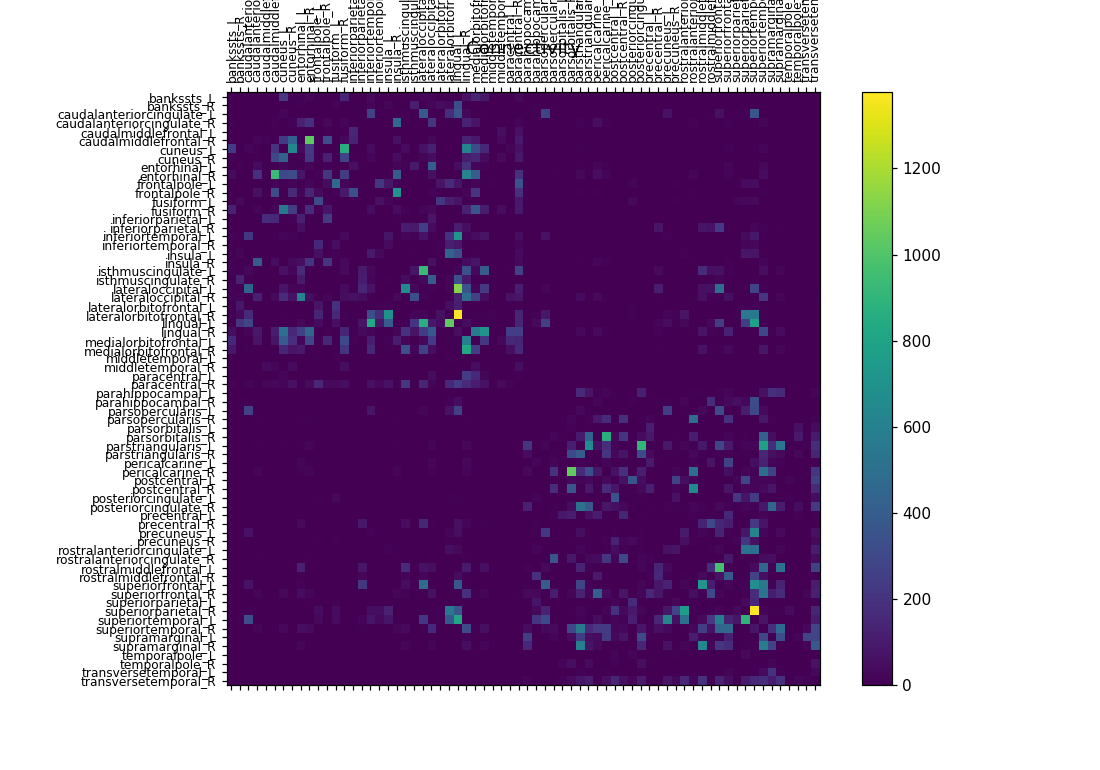

2019-10-28 15:11:52,593 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f70449d0588>
2019-10-28 15:11:52,594 - DEBUG - matplotlib.colorbar - Using auto colorbar locator on colorbar
2019-10-28 15:11:52,594 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f70449d0588>
2019-10-28 15:11:52,595 - DEBUG - matplotlib.colorbar - Setting pcolormesh
2019-10-28 15:11:52,720 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:11:52,720 - DEBUG - matplotlib.axes._base - not adjusting title pos because title was already placed manually: 1.050000
2019-10-28 15:11:52,769 - DEBUG - matplotlib.font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-10-28 15:11:53,049 - DEBUG - matplotlib.font_manager - findfont: Matching :family=sans

<IPython.core.display.Javascript object>


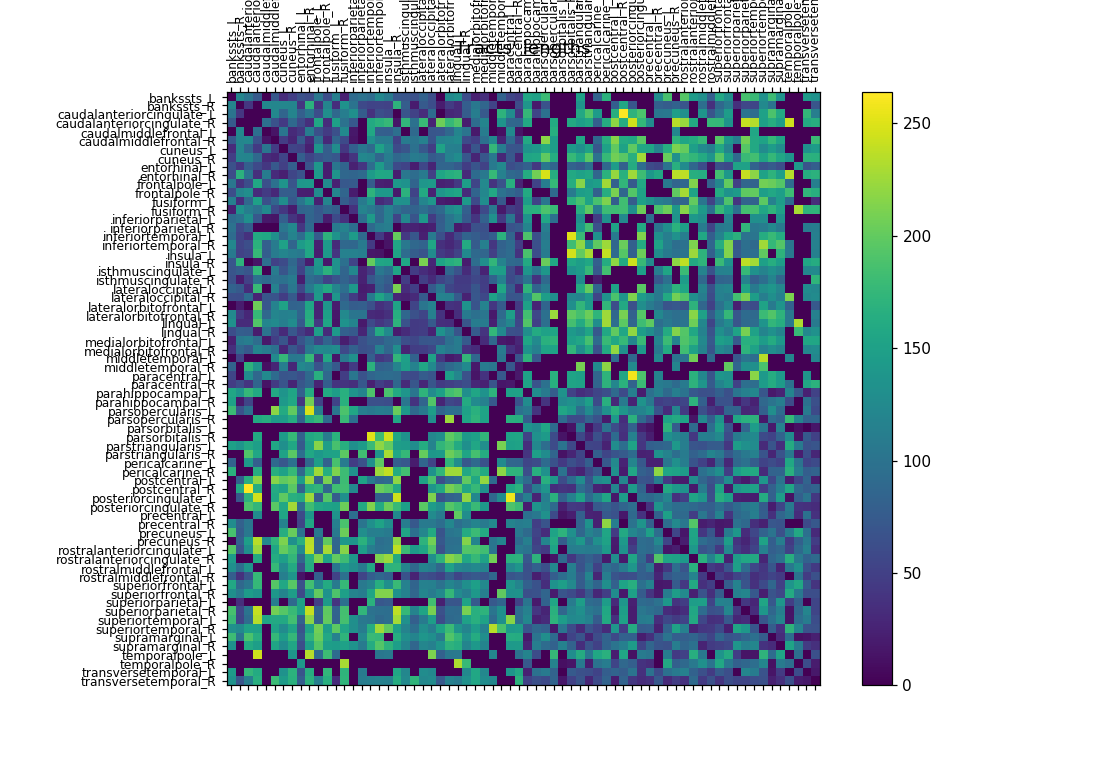

2019-10-28 15:11:53,165 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f703fa3a860>
2019-10-28 15:11:53,166 - DEBUG - matplotlib.colorbar - Using auto colorbar locator on colorbar
2019-10-28 15:11:53,167 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f703fa3a860>
2019-10-28 15:11:53,167 - DEBUG - matplotlib.colorbar - Setting pcolormesh
2019-10-28 15:11:53,282 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:11:53,283 - DEBUG - matplotlib.axes._base - not adjusting title pos because title was already placed manually: 1.050000
2019-10-28 15:11:53,561 - DEBUG - matplotlib.axes._base - update_title_pos


(<Figure size 1000x700 with 2 Axes>,
 <Figure size 1000x700 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f703fac5dd8>)

In [2]:
from tvb.datatypes.connectivity import Connectivity
connectivity = Connectivity.from_file(os.path.join(config.DEFAULT_SUBJECT_PATH,
                                    config.DEFAULT_CONNECTIVITY_ZIP))
connectivity.configure()
plotter.plot_tvb_connectivity(connectivity)

## Prepare TVB simulator <br> (model, integrator, monitors etc)

In [3]:
from tvb_nest.simulator_tvb.simulator import Simulator
from tvb_nest.simulator_tvb.model_reduced_wong_wang_exc_io_inh_i \
    import ReducedWongWangExcIOInhI
from tvb.simulator.monitors import Raw  # , Bold, EEG

# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = Simulator()
simulator.model = ReducedWongWangExcIOInhI()
    
simulator.connectivity = connectivity
simulator.integrator.dt = \
    float(int(np.round(simulator.integrator.dt / 
                       config.nest.NEST_MIN_DT))) * config.nest.NEST_MIN_DT
# Some extra monitors for neuroimaging measures:
mon_raw = Raw(period=simulator.integrator.dt)
# mon_bold = Bold(period=2000.)
# mon_eeg = EEG(period=simulator.integrator.dt)
simulator.monitors = (mon_raw, )  # mon_bold, mon_eeg

2019-10-28 15:11:54,473 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
2019-10-28 15:11:54,476 - WARNING - tvb.traits - default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
2019-10-28 15:11:54,477 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required

2019-10-28 15:11:58,100 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.Generic2dOscillator.state_variable_range = Final(field_type=<class 'dict'>, default={'V': array([-2.,  4.]), 'W': array([-6.,  6.])}, required=True)
2019-10-28 15:11:58,260 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.Kuramoto.state_variable_range = Final(field_type=<class 'dict'>, default={'theta': array([0.        , 6.28318531])}, required=True)
2019-10-28 15:11:58,263 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.SupHopf.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-5.,  5.]), 'y': array([-5.,  5.])}, required=True)
2019-10-28 15:11:58,389 - WARNING

## Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [4]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []  # the indices of fine scale regions modeled with NEST
# We model parahippocampal cortices (left and right) with NEST
for id in range(number_of_regions):
    if simulator.connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_ids.append(id)
        
from tvb_nest.simulator_nest.models_builders.red_ww_exc_io_inh_i \
    import RedWWExcIOInhIBuilder

# Build a NEST network model with the corresponding builder
# Using all default parameters for this example
nest_model_builder = \
    RedWWExcIOInhIBuilder(simulator, nest_nodes_ids, config=config)

# #----Uncomment below to modify the builder by changing the default options:-

# # Common order of neurons' number per population:
# nest_model_builder.populations_order = 100  
# # Spiking populations labels:
# nest_model_builder.populations_names = ["E", "I"]
# # Spiking populations scalings for the number of neurons:
# nest_model_builder.populations_scales = [1.0, 0.7]
# # Some properties for the default synapse to be used:
# nest_model_builder.default_synapse["params"]["rule"] = "fixed_indegree"

# # Connection weights between the distinct populations:
# # Choosing the values resulting from J_N = 150 pA and J_i = 1000 pA [1]
# w_ee = 150.0
# w_ei = -1000.0
# w_ie = 150.0
# w_ii = -1000.0

# # Within region-node connections' weights
# nest_model_builder.population_connectivity_synapses_weights = \
#     np.array([[w_ee, w_ei],  # exc_i -> exc_i, inh_i -> exc_i
#               [w_ie, w_ii]]) # exc_i -> inh_i, inh_i -> inh_i
# nest_model_builder.population_connectivity_synapses_delays = \
#     np.array(nest_model_builder.tvb_dt/4)
# nest_model_builder.population_connectivity_synapses_receptor_types = np.array(0)

# # Among/Between region-node connections
# # Given that w_ee == w_ie = J_N, 
# # and that only the excitatory population of one region-node couples to
# # both excitatory and inhibitory populations of another region-node,
# # we need only one connection type
# nest_model_builder.node_connections = \
#     [{"src_population": "E", "trg_population": ["E", "I"],
#       "model": nest_model_builder.default_synapse["model"],
#       "params": nest_model_builder.default_synapse["params"],
#       "weight": w_ee,  # weight scaling the TVB connectivity weight
#       "delay": 0.0,   # additional delay to the one of TVB connectivity
#       "receptor_type": 0}]

# # Creating devices to be able to observe NEST activity:
# connections = OrderedDict({})
# #          label <- target population
# connections["E spikes"] = "E"
# connections["I spikes"] = "I"
# output_devices.append({"model": "spike_detector", "params": {},
#                        "nodes": None, "connections": connections})
# connections = OrderedDict({})
# connections["E V_m"] = "E"
# connections["I V_m"] = "I"
# params = config.nest.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"]
# output_devices.append({"model": "multimeter", "params": params,
#                       "nodes": None, "connections": connections})

#-----------------------------------------------------------------------------

nest_network = nest_model_builder.build_nest_network()

2019-10-28 15:12:00,274 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.simulator_nest.models.devices.NESTDeviceSet'> of model spike_detector for E spikes created!
2019-10-28 15:12:00,274 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.simulator_nest.models.devices.NESTDeviceSet'> of model spike_detector for E spikes created!
2019-10-28 15:12:00,310 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.simulator_nest.models.devices.NESTDeviceSet'> of model spike_detector for I spikes created!
2019-10-28 15:12:00,310 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.simulator_nest.models.devices.NESTDeviceSet'> of model spike_detector for I spikes created!
2019-10-28 15:12:00,335 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.simulator_nest.models.devices.NESTDeviceSet'> of model multimeter for E V_m created!
2019-10-28 15:12:00,335 - INFO - tvb_nest.simulator_nest.models.devices - <class 'tvb_nest.s

## Build the TVB-NEST interface

In [5]:
from tvb_nest.interfaces.builders.red_ww_exc_io_inh_i import RedWWexcIOinhIBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
# Using all default parameters for this example
tvb_nest_builder = RedWWexcIOinhIBuilder(simulator, nest_network, 
                                         nest_nodes_ids, config=config)

#------------Modifications to the default options of the builder--------------

# NEST -> TVB:
#
# 1.1. For current transmission from TVB to NEST,
# either choose a NEST dc_generator device:
# tvb_nest_builder.tvb_to_nest_interfaces = \
#    [{"model": "dc_generator", "sign": 1,
# #                      TVB  <-  NEST
#      "connections": {"S_e": ["E", "I"]}}]

# 1.2. or modify directly the external current stimulus parameter:
tvb_nest_builder.tvb_to_nest_interfaces = \
    [{"model": "current", "parameter": "I_e", "sign": 1,
      #                TVB  <-  NEST
      "connections": {"S_e": ["E", "I"]}}]

# 2.1. For spike transmission from TVB to NEST:
# tvb_nest_builder.tvb_to_nest_interfaces = \
#    [{"model": "poisson_generator", "sign": 1,
# #                      TVB  <-  NEST
#      "connections": {"S_e": ["E", "I"]}}]

# NEST -> TVB:
# Use S_e and S_i instead of r_e and r_i
# for transmitting to the TVB state variables directly
connections = OrderedDict()
#            TVB <- NEST
connections["r_e"] = "E"
connections["r_i"] = "I"
tvb_nest_builder.nest_to_tvb_interfaces = \
    [{"model": "spike_detector", "params": {}, "connections": connections}]

#-----------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface()

2019-10-28 15:12:00,451 - INFO - tvb_nest.interfaces.base - <class 'tvb_nest.interfaces.models.red_ww_exc_io_inh_i.RedWWexcIOinhI'> created!
2019-10-28 15:12:00,451 - INFO - tvb_nest.interfaces.base - <class 'tvb_nest.interfaces.models.red_ww_exc_io_inh_i.RedWWexcIOinhI'> created!
2019-10-28 15:12:00,453 - INFO - tvb_nest.interfaces.models.red_ww_exc_io_inh_i - <class 'tvb_nest.interfaces.models.red_ww_exc_io_inh_i.RedWWexcIOinhI'> created!
2019-10-28 15:12:00,453 - INFO - tvb_nest.interfaces.models.red_ww_exc_io_inh_i - <class 'tvb_nest.interfaces.models.red_ww_exc_io_inh_i.RedWWexcIOinhI'> created!
2019-10-28 15:12:00,455 - INFO - tvb_nest.interfaces.tvb_to_nest_parameter_interface - <class 'tvb_nest.interfaces.tvb_to_nest_parameter_interface.TVBNESTParameterInterface'> of model current for S_e created!
2019-10-28 15:12:00,455 - INFO - tvb_nest.interfaces.tvb_to_nest_parameter_interface - <class 'tvb_nest.interfaces.tvb_to_nest_parameter_interface.TVBNESTParameterInterface'> of model

## Configure simulator and simulate

In [6]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_nest_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
results = simulator.run(simulation_length=100.0)
print("\nSimulated in %f secs!" % (time.time() - t))

2019-10-28 15:12:00,506 - DEBUG - tvb_nest.simulator_tvb.model_reduced_wong_wang_exc_io_inh_i - building observer with code:
def observe(state):
    S_e,S_i = state
    return numpy.array([S_e,S_i])
2019-10-28 15:12:00,510 - INFO - tvb_nest.simulator_tvb.simulator - Region simulation with 68 ROI nodes
2019-10-28 15:12:00,510 - INFO - tvb_nest.simulator_tvb.simulator - Region simulation with 68 ROI nodes
2019-10-28 15:12:00,514 - DEBUG - tvb_nest.simulator_tvb.simulator - Estimated history shape is (879.3333333333334, 2, 68, 1)
2019-10-28 15:12:00,514 - DEBUG - tvb_nest.simulator_tvb.simulator - Estimated history shape is (879.3333333333334, 2, 68, 1)
2019-10-28 15:12:00,518 - INFO - tvb_nest.simulator_tvb.simulator - Memory requirement estimate: simulation will need about 2.2 MB
2019-10-28 15:12:00,518 - INFO - tvb_nest.simulator_tvb.simulator - Memory requirement estimate: simulation will need about 2.2 MB
2019-10-28 15:12:00,521 - DEBUG - tvb_nest.simulator_tvb.simulator - Given nois

In [7]:
# Gather results in a Timeseries instance
from tvb_scripts.time_series.model import TimeSeriesRegion

source_ts = TimeSeriesRegion(results[0][1], time=results[0][0],
               connectivity=simulator.connectivity,
               labels_ordering=["Time", "Synaptic Gating Variable", "Region", "Neurons"],
               labels_dimensions=
                    {"Synaptic Gating Variable": ["S_e", "S_i"],
                     "Region": simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt)
source_ts.configure()
source_ts

## Gather results and plot them

### Plot spikes' raster and mean spike rate for NEST regions

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:Mean of empty slice.
/usr/lib/python3/dist-packages/numpy/core/_methods.py:85: RuntimeWarning:invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


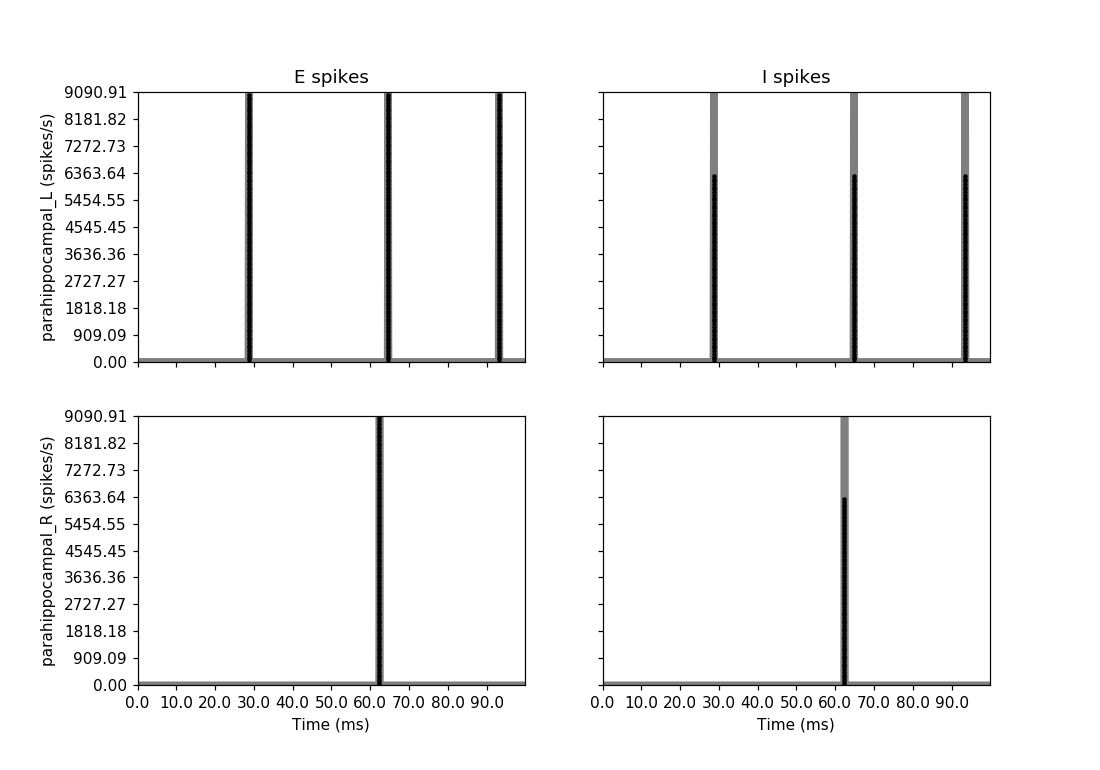

2019-10-28 15:12:07,254 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:12:07,274 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:12:07,296 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:12:07,308 - DEBUG - matplotlib.axes._base - update_title_pos


In [8]:
# Plot spikes and mean field spike rates
rates, max_rate, spike_detectors, time = \
    nest_network.compute_mean_spike_rates(
        spike_counts_kernel_width=simulator.integrator.dt,  # ms
        spike_counts_kernel_overlap=0.0, time=source_ts.time)
plotter.plot_spikes(spike_detectors, time, rates=rates, max_rate=max_rate,
                    title='Population spikes and mean spike rate', 
                    figsize=config.figures.NOTEBOOK_SIZE);

### Plot time series

<IPython.core.display.Javascript object>


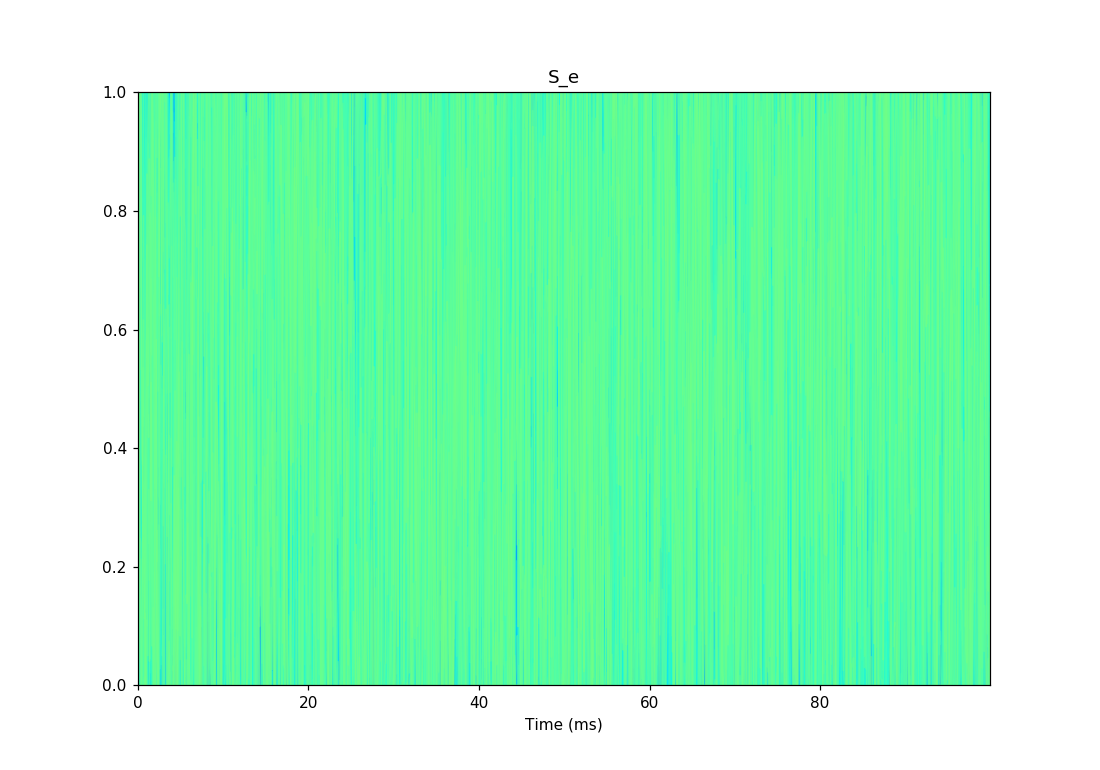

2019-10-28 15:12:07,651 - DEBUG - matplotlib.axes._base - update_title_pos


In [9]:
# Plot timeseries
# Add _tvb from the function names 
# if source_ts is a TVB TimeSeriesRegion object
plotter.plot_timeseries(source_ts.S_e, 
                        title="Excitatory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

<IPython.core.display.Javascript object>


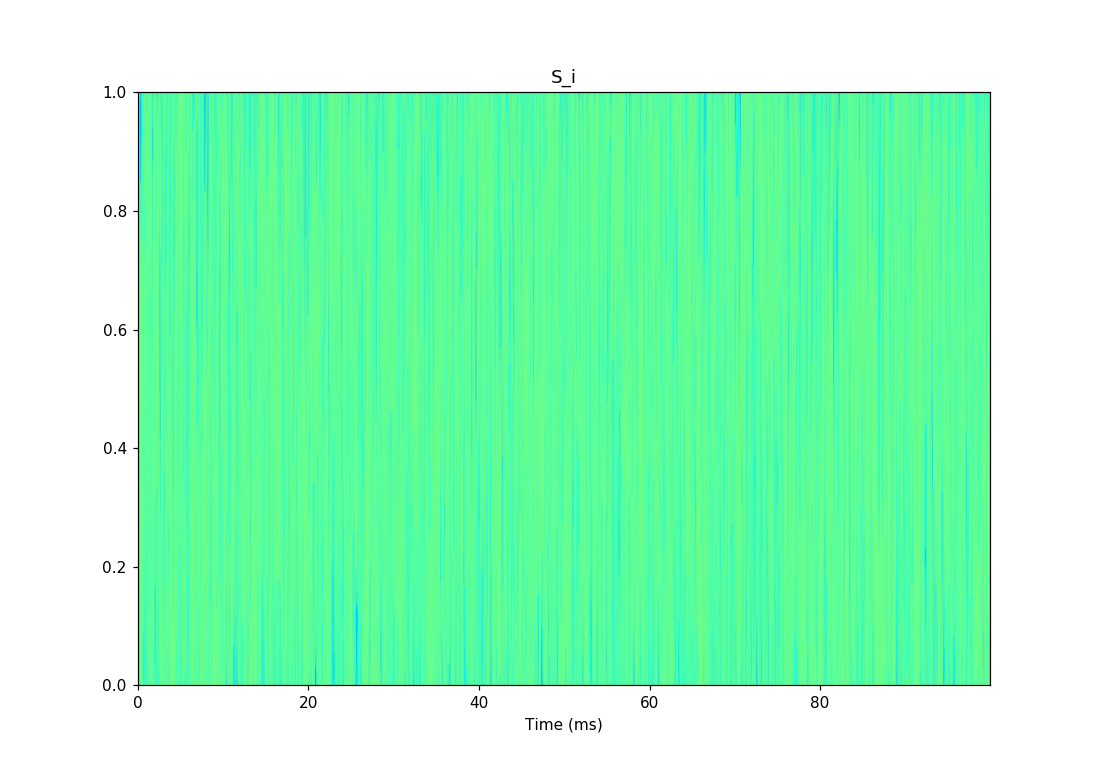

2019-10-28 15:12:08,912 - DEBUG - matplotlib.axes._base - update_title_pos


In [10]:
plotter.plot_timeseries(source_ts.S_i, 
                        title="Inhibitory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

<IPython.core.display.Javascript object>


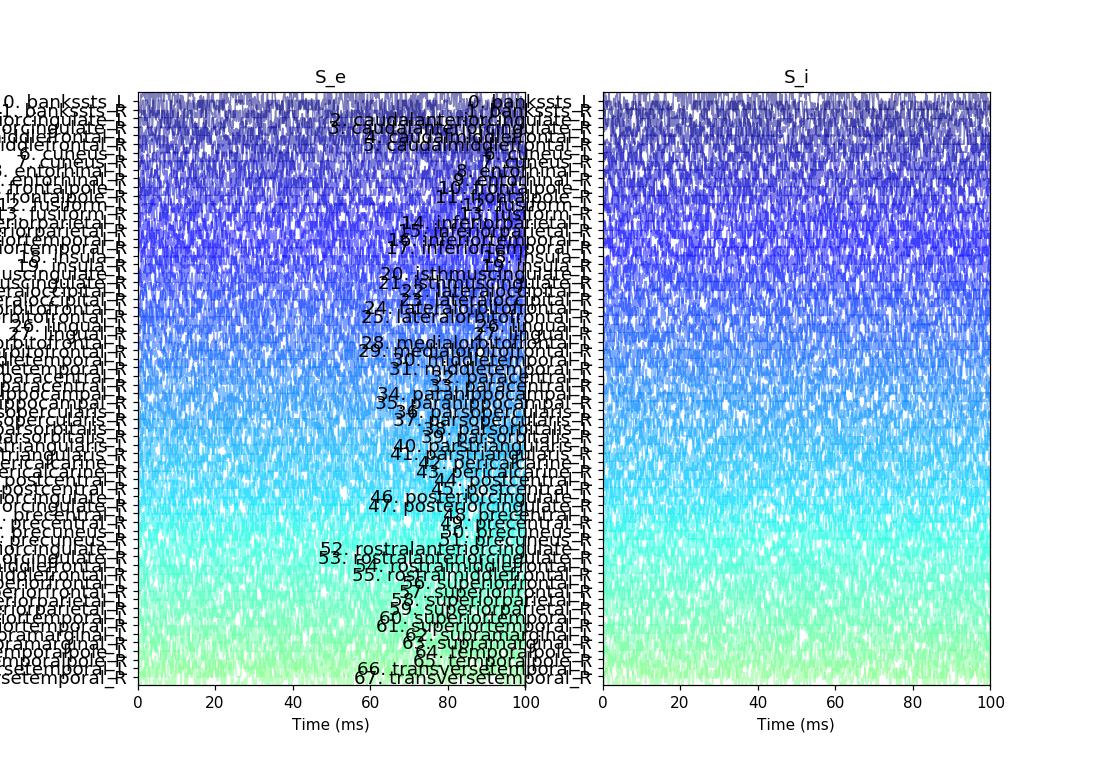

2019-10-28 15:12:10,251 - DEBUG - matplotlib.axes._base - update_title_pos
2019-10-28 15:12:10,470 - DEBUG - matplotlib.axes._base - update_title_pos


In [11]:
# For raster plot:
plotter.plot_raster(source_ts, 
                    title="Region Time Series Raster", 
                    figsize=config.figures.NOTEBOOK_SIZE);

### Interactive time series plot

2019-10-28 15:12:10,938 - INFO - tvb_scripts.plot.time_series_interactive_plotter - Generating an interactive time-series plot for TimeSeriesRegion
2019-10-28 15:12:10,938 - INFO - tvb_scripts.plot.time_series_interactive_plotter - Generating an interactive time-series plot for TimeSeriesRegion


<IPython.core.display.Javascript object>


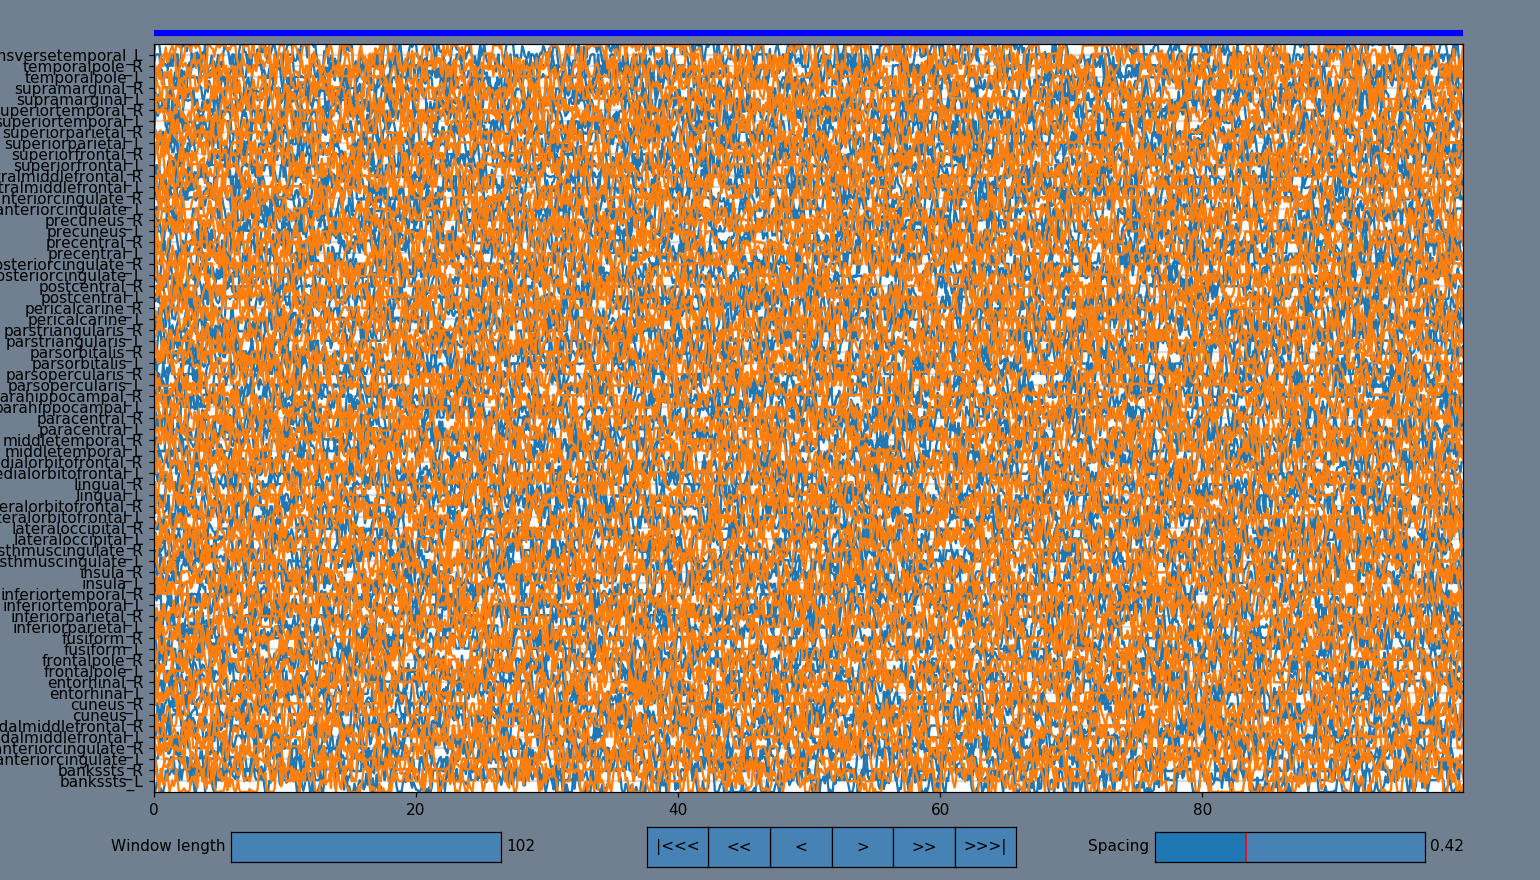

In [12]:
# ...interactively as well
# Use this to skip completely the tvb-scripts plotter
# from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractive
# tvb_plotter = TimeSeriesInteractive(time_series=source_ts._tvb)
# tvb_plotter.configure()
# tvb_plotter.show()
plotter.plot_timeseries_interactive(source_ts)

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>
  
2 Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, <br>
  Patric Hagmann and Maurizio Corbetta. <br>
  Resting-State Functional Connectivity Emerges from Structurally and <br>
  Dynamically Shaped Slow Linear Fluctuations. <br>
  The Journal of Neuroscience 32(27), 11239-11252, 2013.<br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>